# Rock-paper-scissors with Keras/TensorFlow (DCT Type-II / DNN)

Original: 2019/1/19-21, Update: 2023/9/6, 2023/9/14

This notebook uses DCT Type-II coefficients as image features for DNN (Dense Neural Network).

Classification: rock, paper, 
scissors

## Preparing data set for DNN

In [1]:
DATA_FOLDER = '../STM32/Thermography/GUI/data/'
SCREENSHOTS_FOLDER = '../STM32/Thermography/GUI/screenshots/'

#FILES = 45
#TRAINING_FILES = 30 
#TEST_FILES = FILES - TRAINING_FILES

LENGTH = 2 + 3 + 4 + 5 + 6
LENGTH

20

In [2]:
%matplotlib inline
%run ./zigzag.py

import matplotlib.pyplot as plt
import numpy as np
import time
import random
import os
import sklearn.preprocessing as pp
from scipy.fftpack import dct, idct
import glob

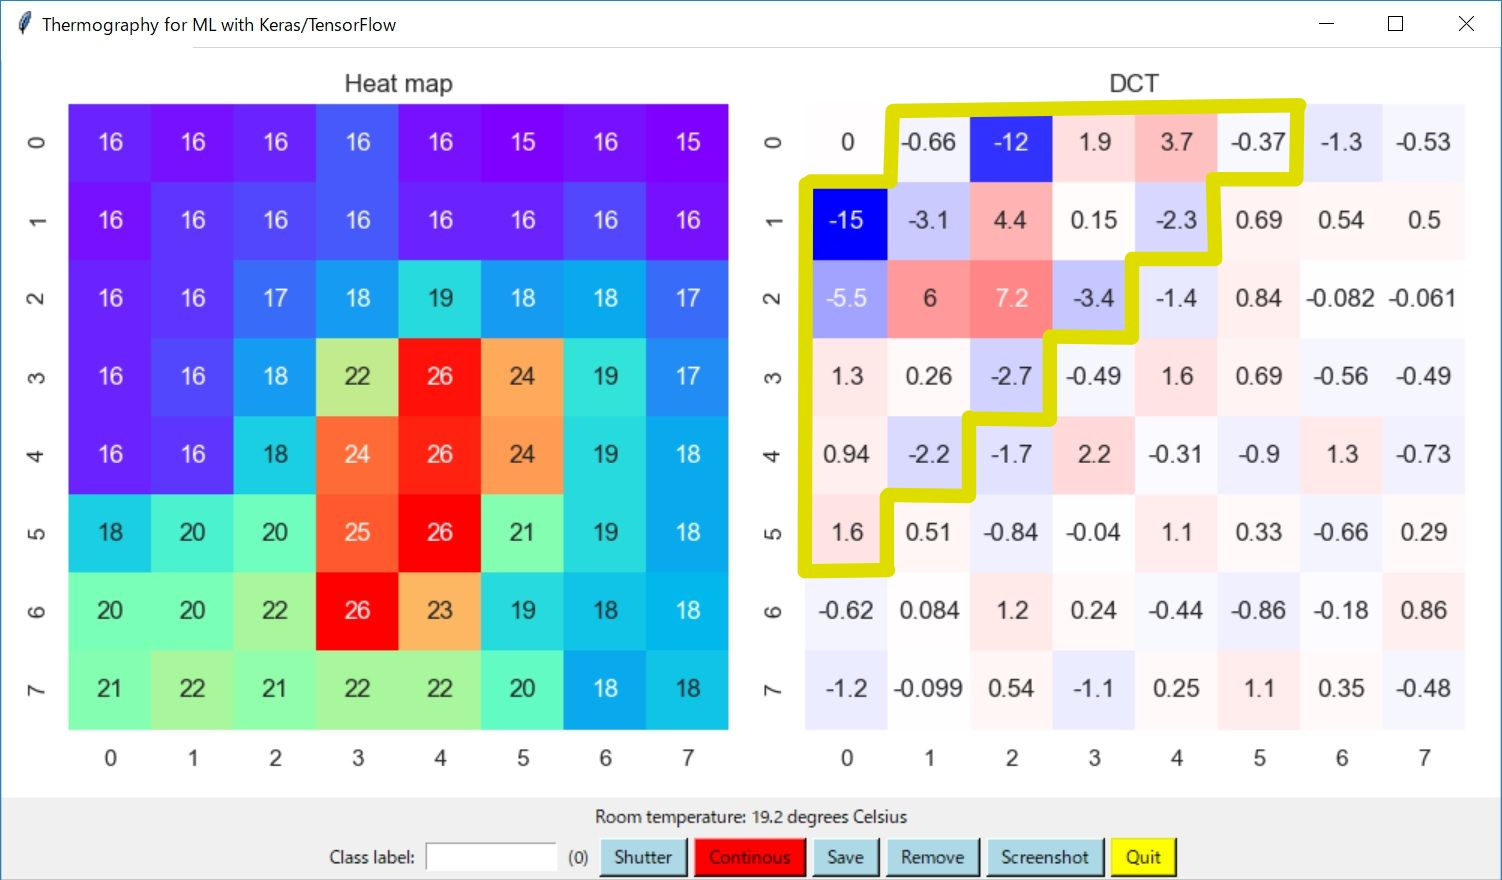

In [3]:
from IPython.display import Image
Image(filename=SCREENSHOTS_FOLDER + 'dct_higher_freqs.jpg', width=600, height=600)

In [4]:
data_files = glob.glob(DATA_FOLDER+'*.csv')
num_all_files = len(data_files)

In [5]:
data_files[0]

'../STM32/Thermography/GUI/data\\paper-20190104211500.csv'

In [6]:
class_labels = {}

for file in data_files:
    label = file.split('-')[0].replace('\\', '/').split('/')[-1]
    if label not in class_labels:
        class_labels[label] = 1
    else:
        class_labels[label] += 1

class_labels

{'paper': 140, 'rock': 140, 'scissors': 140}

In [7]:
#Check if all values of class labels is equal to each other 
if (len(set(class_labels.values())) == 1):
    print('Check OK')
else:
    print('Check NG')

Check OK


In [8]:
num_classes = len(class_labels.keys())
num_files = list(class_labels.values())[0]
num_train_files = int(num_files * 4/5)
num_test_files = num_files - num_train_files
'num_classes: {}, num_train_files: {}, num_test_files: {}'.format(num_classes, num_train_files, num_test_files)

'num_classes: 3, num_train_files: 112, num_test_files: 28'

In [9]:
data_set = {}

class_number = 0

for label in class_labels:
    files = glob.glob(DATA_FOLDER+'{}-*.csv'.format(label))
    random.shuffle(files)
    data_set[label] = (files[:num_train_files], files[num_train_files:num_files], class_number)
    class_number += 1

In [10]:
training_set = []
test_set = []

In [11]:
for k, v in data_set.items():
    files = v[0]
    class_number = v[2]
    for file in files:
        with open(file) as f:
            data = np.array(f.read().split(',')).astype(float)
            training_set.append((data, class_number))
    files = v[1]
    for file in files:
        with open(file) as f:
            data = np.array(f.read().split(',')).astype(float)
            test_set.append((data, class_number))
random.shuffle(training_set)
random.shuffle(test_set)

In [12]:
training_set[0]

(array([20.8, 24.8, 26.8, 27.5, 25.2, 19. , 18.2, 17.8, 21. , 24.2, 27. ,
        26.8, 24.5, 19. , 18. , 17.5, 20. , 23.2, 26.5, 25. , 19.8, 17.8,
        17.2, 17.8, 19.8, 24.2, 20.8, 24.2, 19. , 18.2, 17.8, 17.5, 19. ,
        23.8, 19. , 23.5, 19.8, 18.2, 17.5, 18. , 18.8, 20.5, 18.8, 21.2,
        21. , 18.2, 18. , 17.5, 17.2, 18. , 17.8, 18. , 19. , 18.2, 17.8,
        17.8, 18. , 18. , 17.8, 17.5, 18. , 18. , 18. , 17.8]),
 2)

In [13]:
class_labels = [None for _ in range(len(data_set))]

# Class number and class labels
for k,v in data_set.items():
    print('{}: {}'.format(v[2],k))
    class_labels[v[2]] = k
    
import yaml
with open(DATA_FOLDER+'class_labels.yaml', 'w') as f:
    yaml.dump(class_labels, f)

0: paper
1: rock
2: scissors


In [14]:
train_data, train_labels = [], []
test_data, test_labels = [], []

In [15]:
def gen_data_labels(data_set):
    d = []  # data
    l = []  # labels
    for img, label in data_set:
        img = img.reshape(8,8)
        img = dct(dct(img, norm='ortho').T, norm='ortho').T
        img[0,0] = 0
        img = zigzag_scan(img.flatten())[:LENGTH+1]
        img = img[1:LENGTH+1]
        img = pp.scale(img)  # Standardization
        d.append(img)
        l.append(label)
    d = np.array(d)
    l = np.array(l, dtype=np.uint8)
    return (d, l)

train_data, train_labels = gen_data_labels(training_set)
test_data, test_labels = gen_data_labels(test_set)

In [16]:
train_data[0]

array([ 2.04773105e+00,  2.48205949e+00,  8.80098085e-02,  1.47170260e+00,
       -1.73779539e+00, -1.14203389e+00, -1.24008154e+00, -2.75507799e-01,
        3.17126149e-01, -7.84117791e-04, -1.25055816e-01, -2.87147680e-01,
       -1.02635972e+00,  1.35089153e-01, -2.32338123e-01,  1.77949147e-02,
        1.02907493e-01, -3.37987071e-01,  3.27123776e-02, -2.90041895e-01])

In [17]:
test_labels

array([0, 0, 2, 0, 1, 2, 2, 1, 2, 2, 0, 2, 1, 1, 1, 1, 0, 0, 0, 2, 0, 0,
       1, 2, 0, 1, 0, 1, 0, 0, 0, 1, 2, 0, 0, 0, 1, 0, 2, 1, 2, 0, 1, 2,
       2, 1, 1, 2, 2, 1, 0, 2, 1, 0, 1, 1, 2, 1, 2, 0, 1, 2, 0, 2, 0, 1,
       2, 2, 1, 1, 2, 2, 1, 2, 2, 1, 1, 2, 0, 0, 0, 2, 1, 0], dtype=uint8)

In [18]:
from keras.utils import to_categorical

train_labels=to_categorical(train_labels)
test_labels=to_categorical(test_labels)

In [19]:
train_labels[0]

array([0., 0., 1.], dtype=float32)

## DNN model

In [20]:
LENGTH

20

In [21]:
from keras import layers
from keras import models

model = models.Sequential()

model.add(layers.Dense(int(LENGTH*1.3), activation='relu', input_shape=(LENGTH,)))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(int(LENGTH*1.3), activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(len(class_labels), activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 26)                546       
                                                                 
 dropout (Dropout)           (None, 26)                0         
                                                                 
 dense_1 (Dense)             (None, 26)                702       
                                                                 
 dropout_1 (Dropout)         (None, 26)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 81        
                                                                 
Total params: 1329 (5.19 KB)
Trainable params: 1329 (5.19 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [22]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

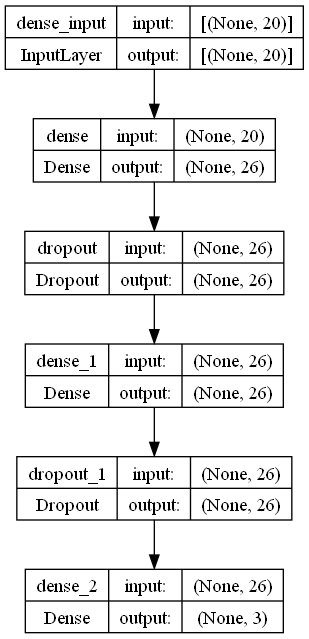

In [23]:
from IPython.display import SVG
from keras.utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True)

In [24]:
EPOCHS = 300
history = model.fit(train_data, train_labels, epochs=EPOCHS, validation_data=(test_data, test_labels))

Epoch 1/300
11/11 [==============================] - 2s 44ms/step - loss: 1.3521 - accuracy: 0.3006 - val_loss: 1.1063 - val_accuracy: 0.3571
Epoch 2/300
11/11 [==============================] - 0s 11ms/step - loss: 1.2405 - accuracy: 0.3274 - val_loss: 1.0841 - val_accuracy: 0.4762
Epoch 3/300
11/11 [==============================] - 0s 8ms/step - loss: 1.1868 - accuracy: 0.3482 - val_loss: 1.0673 - val_accuracy: 0.4881
Epoch 4/300
11/11 [==============================] - 0s 8ms/step - loss: 1.1188 - accuracy: 0.3780 - val_loss: 1.0558 - val_accuracy: 0.4286
Epoch 5/300
11/11 [==============================] - 0s 7ms/step - loss: 1.1115 - accuracy: 0.3899 - val_loss: 1.0485 - val_accuracy: 0.4524
Epoch 6/300
11/11 [==============================] - 0s 7ms/step - loss: 1.1325 - accuracy: 0.3631 - val_loss: 1.0426 - val_accuracy: 0.4405
Epoch 7/300
11/11 [==============================] - 0s 9ms/step - loss: 1.0968 - accuracy: 0.4107 - val_loss: 1.0344 - val_accuracy: 0.4286
Epoch 8/300

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


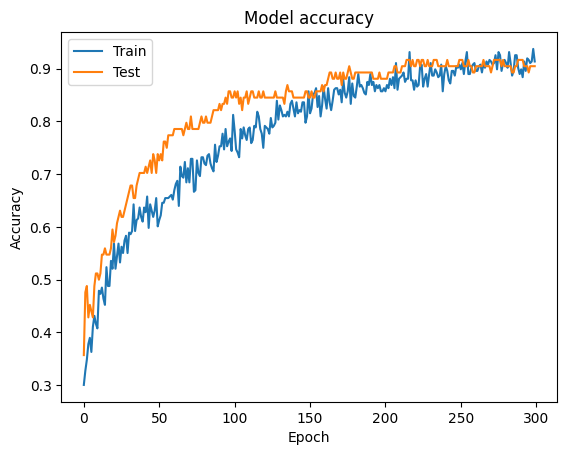

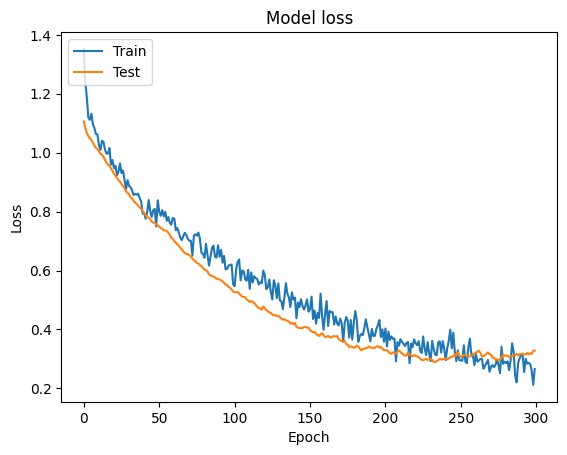

In [25]:
print(history.history.keys())

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Save the model

In [34]:
import datetime

dt = datetime.datetime.today().strftime('%Y%m%d%H%M%S')
filename = 'rock_paper_scissors_dct_{}.h5'.format(dt)
model.save(filename)

## load the model

In [27]:
del model
model = models.load_model(filename)

## Confirmation

In [28]:
import numpy as np
import matplotlib.pyplot as plt
train_data.shape

(336, 20)

In [29]:
layer_outputs = [layer.output for layer in model.layers]

In [30]:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(test_data)

3/3 [==============================] - 0s 4ms/step


In [31]:
class_labels

['paper', 'rock', 'scissors']

In [32]:
(activations[-1][:10]*100).astype(int)

array([[ 98,   0,   0],
       [ 93,   2,   3],
       [  4,   7,  88],
       [ 96,   2,   1],
       [  0, 100,   0],
       [ 47,  52,   0],
       [  0,   1,  98],
       [  0,  99,   0],
       [  3,   3,  92],
       [  1,   8,  90]])

In [33]:
test_labels[:10].astype(int)

array([[1, 0, 0],
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 0, 1],
       [0, 1, 0],
       [0, 0, 1],
       [0, 0, 1]])